# Урок 4. Задача uplift-моделирования

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

## Выполнение

#### Импорт библиотек

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pprint import pprint

### скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [2]:
df = pd.read_csv('Data/HW_4_data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


### там поле conversion - это целевая переменная, а offer - коммуникация. 
Переименовать поля (`conversion -> target`, `offer -> treatment`) и привести поле `treatment` к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение `No Offer` означает отсутствие коммуникации, а все остальные - наличие.

In [3]:
# преименование полей
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})

In [4]:
# приведение значений к бинарным
df['treatment'] = df['treatment'].apply(lambda i : 0 if i == 'No Offer' else 1)

In [5]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

### сделать разбиение набора данных не тренировочную и тестовую выборки

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1),
                                                    df['target'],
                                                    test_size=0.33,
                                                    random_state=42)

### сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [7]:
# One-Hot Encoding:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

### провести uplift-моделирование 3 способами: 
- одна модель с признаком коммуникации (S learner), 
- модель с трансформацией таргета (трансформация классов п. 2. 1) и 
- вариант с двумя независимыми моделями

#### Заведем переменные

In [8]:
treat_train = X_train['treatment']
treat_test = X_test['treatment']
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@30%': []
}

#### - одна модель с признаком коммуникации (S learner), 

In [9]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/

In [10]:
# !pip install scikit-uplift
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

In [11]:
# !pip install catboost
from catboost import CatBoostClassifier

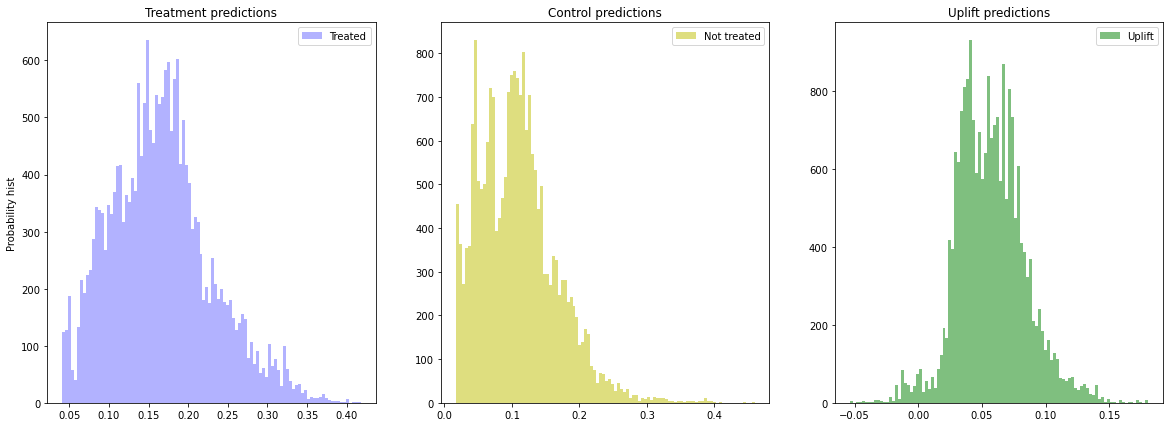

In [12]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@30%'].append(sm_score_30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Посмотрим на топ-признаки

In [13]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,19.230532
1,treatment,15.733649
2,recency,12.950256
3,history,12.842657
4,used_bogo,12.393245
5,used_discount,7.896263
6,zip_code_Rural,7.563466
7,channel_Phone,5.956007
8,channel_Web,2.397393
9,channel_Multichannel,1.644685


#### - модель с трансформацией таргета (трансформация классов п. 2. 1) и 

In [14]:
from sklift.models import ClassTransformation

In [15]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@30%'].append(ct_score_30)

<ipython-input-15-481775445c2c>:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train)


#### - вариант с двумя независимыми моделями

In [16]:
from sklift.models import TwoModels

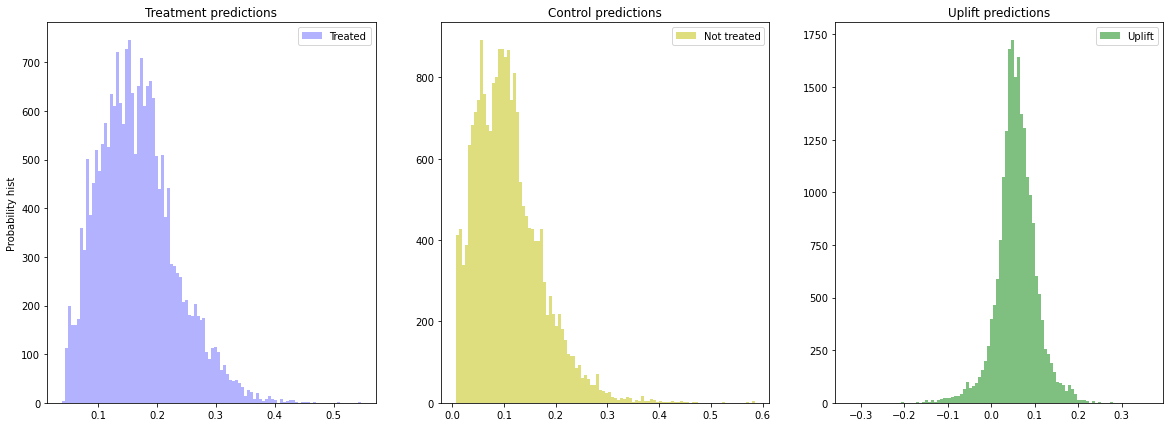

In [17]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla')

tm = tm.fit(
    X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@30%'].append(tm_score_30)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

### в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [18]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False).set_index('approach')

,uplift@10%,uplift@30%
approach,,
ClassTransformation,0.269593,0.183394
SoloModel,0.092437,0.085607
TwoModels,0.082563,0.082071


### построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [19]:
X_train_tree = X_train.copy()
features = [col for col in X_train_tree]

In [28]:
# !pip install causalml

In [26]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

ModuleNotFoundError: No module named 'causalml'

**NB! Не получатеся пока установить `causalml`**

In [47]:
uplift_model = UpliftTreeClassifier(max_depth=4,
                                    min_samples_leaf=200,
                                    min_samples_treatment=50,
                                    n_reg=100,
                                    evaluationFunction='KL',
                                    control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({
                     1: 'treatment1',
                     0: 'control'
                 }).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

### (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion

### (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево